
Minimal Network (Euler 107), a naturally occuring matroid. 
---
---

**Spoiler alert** This contains a solution to the euler project problem 107, so don't read it if you haven't solved it yet. The topic of this exposition however is to illustrate the usefullness of a mathematical object called a *matroid*. 

[This problem](https://projecteuler.net/problem=107) asks us to find a minimum spanning tree (MST) in a weighted network, then calculate the savings by pruning the graph to this MST. 

We'll implement Kruskal's algorithm, which most CS majors learn as part of the canon of essential graph algorithms.  However for mathematicians, this is a classic example of the **greedy algorithm** for optimizing a weight function over a [matroid](https://en.wikipedia.org/wiki/Matroid).

It is a theorem of Richard Rado that the greedy algorithm produces an optimal set over a family of sets $M$ if and only if $M$ is a matroid. In fact, the greedy algorithm completely characterizes matroids. We'll explore this in the very specific case where we are using the greedy algorithm to construct a minimum spanning tree.  

---
The Matroid over a graph
---
Let's begin by identifying the salient properties of the sets that we're trying to optimize over. Our ground set in this case is the set of edges $E = \{ (v,w) \in V\times V \}$ of a graph $G$ on $V$.  The subsets that we're concerned about are called *forests* or sets of edges that do not form a cycle, i.e. a bunch of *trees* of the graph. We call a set of edges *independent* if they form a forest. Maximal indpendent sets, or bases, are spanning trees $\mathcal{T}$ (assuming that the graph is connected).  

Independence among a set of edges means that the two vertices that an edge connects cannot be connected by any combination of the other edges.   Matroids will abstract this property of independence into a characterization of *families of sets*.

In [2]:
%load_ext tikzmagic

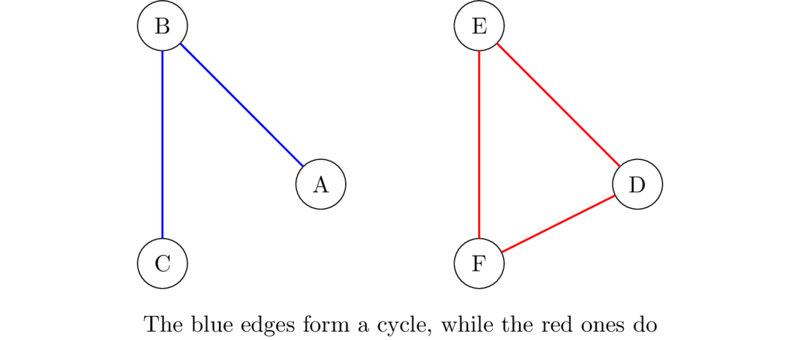

In [3]:
%%tikz -s 800,600 -sc 1.2 -f png -l arrows,petri,topaths -p tkz-berge -c "The blue edges don't form a cycle, while the red ones do"
\tikzstyle{VertexStyle} = [shape=circle,minimum width=5ex,draw]   
\Vertex[x=-1,y=1]{A}
\Vertex[x=-3,y=3]{B}
\Vertex[x=-3,y=0]{C}
\Edge[style={blue}](A)(B)
\Edge[style={blue}](B)(C)

\Vertex[x=3,y=1]{D}
\Vertex[x=1,y=3]{E}
\Vertex[x=1,y=0]{F}
\Edge[style={red},](D)(E)
\Edge[style={red}](E)(F)
\Edge[style={red},](F)(D)

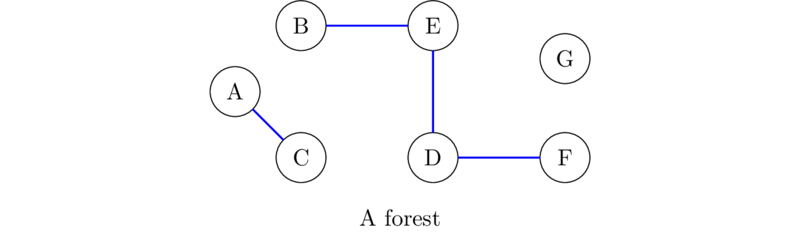

In [6]:
%%tikz -s 800,600 -sc 1 -l arrows,petri,topaths -p tkz-berge -c "A forest"
\tikzstyle{VertexStyle} = [shape=circle,minimum width=5ex,draw]   
\Vertex[x=-4,y=1]{A}
\Vertex[x=-3,y=2]{B}
\Vertex[x=-3,y=0]{C}
\Vertex[x=-1,y=0]{D}
\Vertex[x=-1,y=2]{E}
\Vertex[x=1,y=0]{F}
\Vertex[x=1,y=1.5]{G}

\Edge[style={blue}](A)(C)
\Edge[style={blue}](D)(E)
\Edge[style={blue}](E)(B)
\Edge[style={blue}](F)(D)


While there are many [*cryptomorphic*](https://en.wikipedia.org/wiki/Cryptomorphism) definitions of a matroid, we will use the definition characterizing the **bases**, or maximal independent sets. 

---------------------------------------

> **Definition:**   A **matroid** is a family of sets $\mathcal{B}$ called *bases* where for all $A,B \in \mathcal{B}$, and any $a$ in $A\setminus B$ we can find a $b \in B\setminus A$ such that when we take out $a$ from $A$ and replace it with $b$ we get a set that is still a basis.  This is called the **basis exchange property**. Any subset of a base is called *independent.* 

---------------------------------------


Notably, that means we can visit all the bases of a matroid by simple swaps of two elements at a time.  In this context, the basis exchange property says that given two trees, $T$ and $S$, if $g\in T \setminus S$ then there should be an $f\in S\setminus T$ such that $T+f-g$ is also a tree. Let's verify that $\mathcal{T}$ is indeed a set of bases of a matroid. 

> *If $f\in S\setminus T $ then removing it creates connected components partitioning $Vert(G)=A\sqcup B$ into disjoint sets.   Since $T$ is a spanning tree, there must an edge $g\in T$ connecting $A$ and $B$, however this edge cannot be $S$ since $e$ is the only bridge between these two components in $S$.  Therefore $S-f+g$ is once again a spanning tree. In fact $T-g+f$ is also still a tree.*

So the set of spanning trees actually satisfies a **strong exchange property** and does indeed form a matroid.  This will give us a bit more machinery to prove that the greedy algorithm will produce an optimum.

### Adding weights to a graph
In an abstract graph, we might only be concerned about connectivty between vertices, however the graphs we find in the real world often have weights, or values associated with edges.   In a map, there are distances between points.  In a circuit, there is resistence, etc.  When we have a weight function $w:E \rightarrow \bf{R}$ that assigns a value to each edge in the graph, then all spanning trees are not equal. Defining the weight of a set of edges $S$ to be the sum of the weight of edges, there is a *minimal spanning tree* with respect to a weight function $w$.  Note that if $w$ doesn't assign *unique* weights, then there might not be a unique MST. 


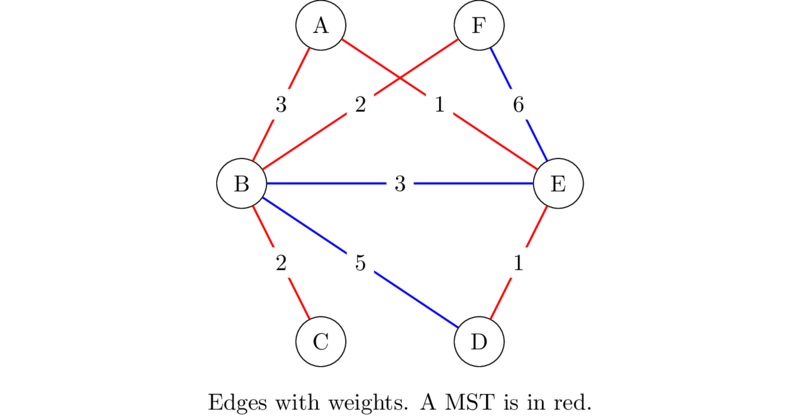

In [16]:
%%tikz -s 800,600 -sc 1.2 -f png -l arrows,petri,topaths -p tkz-berge -c "Edges with weights. A MST is in red."
\tikzstyle{VertexStyle} = [shape=circle,minimum width=5ex,draw]   
\Vertex[x=-1,y=4]{A}
\Vertex[x=-2,y=2]{B}
\Vertex[x=-1,y=0]{C}
\Vertex[x=1,y=0]{D}
\Vertex[x=2,y=2]{E}
\Vertex[x=1,y=4]{F}

\Edge[style={red}, label=1](A)(E)
\Edge[style={red},label=3](A)(B)
\Edge[style={red},label=2](B)(C)
\Edge[style={red},label=1](D)(E)
\Edge[style={blue},label=5](D)(B)
\Edge[style={blue},label=3](E)(B)
\Edge[style={blue},label=6](E)(F)
\Edge[style={red},label=2](F)(B)


### The Greedy Algorithm

As mentioned ealier the **greedy algorithm** is another way to charaterize matroids.  That is, if $M$ is a matroid, then for any weight function, the greedy algorithm will produce an optimum.  But what is the greedy algorithm?!  It can be stated like this: 
 
 Suppose we have a weight function $w$ on the ground set $E$.   We want to find the set in $\mathcal{B}$ that has the smallest weight (or largest, it can work for that too). Let $T_0=\emptyset$ be the bucket we use to construct our optimal set.  

<hr>
$\cdot$ pick the smallest (with respect to $w$) element of $E$ and add it to $T_0$.

**while** $T_i$ is not a base:

&nbsp;&nbsp;&nbsp;$\cdot$  add the smallest element $e$ such that $T_i = T_{i-1}\cup{e}$ is independent.
<hr>


When we perform the greedy algorithm on the matroid over trees of a graph, it is called **Kruskall's algorithm**.   In verifying that the greedy algorithm produces an MST, we will use the fact that at any iteration we have a set of independent edges $T_i$ that is contained in a spanning tree $B_i$.   Now we're ready to show the optimality of the algorithm:

> *Let $w: E \rightarrow \bf{R}^+$ be the weight function on the edges. We'll verify that at every step $T$ is contained in a MST.*

> *Suppose at iteration $i$ we make a set $T_i$ that is contained in a base $B_i$ that is not optimal for the first time. Let $e$ be the element we add at this iteration.  Since $T_{i-1}\subset B_{min}$ where $B_{min}$ is a MST, we can use the strong exchange property to replace an $f\in B_{min}\setminus T_{i-1}$ with $e$. However all such $f$ will have equal or larger weight than $e$ since $e$ minimizes $w(T_{i-1}+e)$ over all $e$ not forming a cycle meaning $w(B_{min}) \geq w(B_{min}-f+e)$.*

> *But the minimality of $B_{min}$ implies that $w(B_{min}) \leq w(B_{min}-f+e)$ proving that $w(f) = w(e)$, and $B_i$ has to be minimal as well.  
This means that at any step, we're safely within a MST and in particular that $T_{n-1}$ is itself a MST.* 

 Ok so now how do we implement this?  Let's get the data loaded first: 

In [1]:
# Assuming you have the data file handy...

edges = []
network_data = open("../data/p107_network.txt",'r')
lines = [l.split(",") for l in network_data.readlines()]
num_vertices = len(lines[0])

# since this is an undirected graph, the adjacency matrix is symmetric and we only have to worry about the bottom triangle. 
for i in range(num_vertices):
    for j in range(i):
        if lines[i][j] != '-':
            edge = (int(lines[i][j]), i, j)
            edges.append(edge)

edges.sort()

Now we have a set of edges sorted from smallest to largest, but how do we check at each iteration whether or not an edge forms a cycle with current edges? We can hack our way through this, but a data structure that keeps track of a *partitioning* of our set of vertices by connectivity would be ideal.  

For example, when we have not edges in $T$, no vertex is connected so everybody is in their own set. Then once we add one edge,$(u,v)$ we merge the two sets $\{u\}$ and $\{v\}$ into $\{u,v\}$, and our partition is *coarsened*. Then checking whether an edge $(x,y)$ forms a cyle we simply have to check if $x$ and $y$ are in the same block of the partition.

Below we illustrate how the data structure should change after an iteration of the greedy algorithm. 

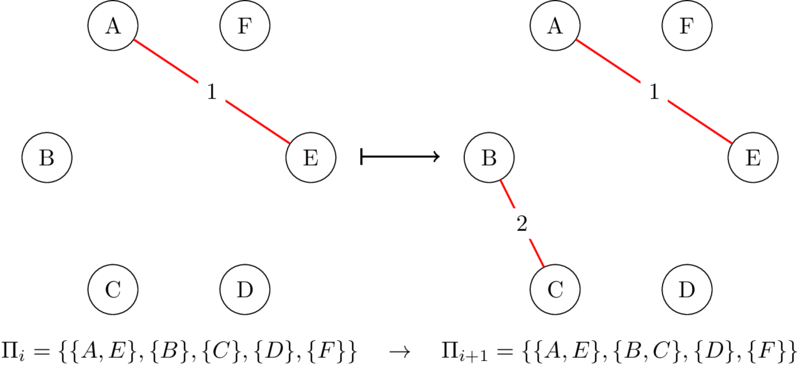

In [11]:
%%tikz -s 800,600 -sc 1 -f png -l arrows,petri,topaths -p tkz-berge -c "$\Pi_i=\{\{A,E\},\{B\}, \{C\},\{D\},\{F\}\}\quad \rightarrow \quad \Pi_{i+1}=\{\{A,E\},\{B,C\},\{D\},\{F\}\}$"

\tikzstyle{VertexStyle} = [shape=circle,minimum width=5ex,draw]   
\Vertex[x=-1,y=4]{A}
\Vertex[x=-2,y=2]{B}
\Vertex[x=-1,y=0]{C}
\Vertex[x=1,y=0]{D}
\Vertex[x=2,y=2]{E}
\Vertex[x=1,y=4]{F}

\Edge[style={red}, label=1](A)(E)

\end{tikzpicture}\quad\begin{tikzpicture}[scale=1.2]
\node[x=2,y=0,inner sep=0,minimum size=0]  {};
\draw [thick,|->] (0,2) to (1,2); 
\end{tikzpicture}\quad\begin{tikzpicture}

\tikzstyle{VertexStyle} = [shape=circle,minimum width=5ex,draw]   
\Vertex[x=-1,y=4]{A}
\Vertex[x=-2,y=2]{B}
\Vertex[x=-1,y=0]{C}
\Vertex[x=1,y=0]{D}
\Vertex[x=2,y=2]{E}
\Vertex[x=1,y=4]{F}

\Edge[style={red}, label=1](A)(E)
\Edge[style={red},label=2](B)(C)

### Creating a Partition data structure

We'll call this object a "Partition", to be consistent with vocabulary, but in the CS 
literature this is called a "disjoint-set" or "union-find" data structure. 
Note that there are much more efficient ways of implementing this data structure. 
* **`merge(x,y)`** will merge the blocks of the partition containing the elements $x$ and $y$
* **`areTogether(x,y)`** returns True if $x$ and $y$ are in the same block and false otherwise.
* **`find(x)`** returns the *block* of the partition containing x, stored in the list `partition.blocks`


In [13]:
class Partition:
    def __init__(self,n):
        self.partitions = {}
        self.blocks = [set([i]) for i in range(n)]
        for i in range(n):
            self.partitions[i] = self.blocks[i]
        
    def merge(self,x,y):
        A = self.find(x)
        B = self.find(y)
        if A == B:
            return
        else:
            C = A.union(B)
            self.blocks.remove(A)
            self.blocks.remove(B)
            self.blocks.append(C)
            i = self.blocks.index(C)
            for e in C:
                self.partitions[e] = self.blocks[i]
    
    def areTogether(self,x,y):
        return self.find(x) == self.find(y)
       
    def find(self,x):
        return self.partitions[x]
        

### Implementing Kruskall's Algorithm

Now using our Partition data structure, we can simply go through all the edges and greedily add the smallest ones that don't form a cycle.  At each step we simply have to check whether or not the two vertices of the edge are already joined together by our current set of edges, i.e. that the edge forms a cycle. 

We don't have to actually keep track of which edges we're adding to our MST, just their weights.   So we'll just accumulate the weights of our MST in `min_sum`.    


In [15]:
connected_components = Partition(num_vertices)
min_sum = 0

for (weight,v,w) in edges:
    if connected_components.areTogether(v,w):
        continue
    else:
        min_sum += weight
        connected_components.merge(v,w)
        
    # if we've reached a spanning tree, we're done
    if len(connected_components.blocks) == 1:
        break

print("Minimum weight: " + str(min_sum))


Minimum weight: 2153


To actually answer the question however, you will need to go back an calculate the sum of all the weights in the network. However now we have a basic idea of what a matroid is, and have seen that the concept of *independence* can be found many situations involving optimization over discrete structures, and linear geometry. Be on the lookout!